# Los Angeles Airbnb listings analysis
In this notebook we try to understand the market of short term rentals on Airbnb.
We will answer the following questions:
* How is the price distributed geographically? What neighborhoods are most expensive/cheap, what neighborhoods have the biggest selection of the listings?
* How do listings features affect the price? What are the most important features?
* How well can we predict the price of the listing based on its features? Based on the features, can we predict the price range that the listing will most likely fit in?

To answer these questions we will use the listings dataset for LA available at http://insideairbnb.com/get-the-data.html


## Data overview

In [1]:
# import libraries we will need later
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import operator
import matplotlib.pyplot as plt
import geopandas as gpd
from collections import OrderedDict
from scipy import stats
from gmplot import gmplot
import requests, json, sys
from colour import Color
from scipy import stats
%matplotlib inline
coords=gpd.read_file('neighbourhoods.geojson')
listings=pd.read_csv('listings.csv')
def price_to_float(x):
    if type(x) is float:
        #return np.nan
        return x
    else:
        x=x.replace(',','')
        return float(x[1:])
# convert the price from string to float:
listings['price']=listings['price'].apply(price_to_float)
# shape of the dataframe and number of missing price data
print('data shape',listings.shape)
print(listings.columns)


data shape (44504, 96)
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodate

Our dataset consists of 44504 data points, with 96 features with information about host, type of the room, property type, policies, amenities, location, review scores and the price.

## 1. Data cleaning: 
1.1. Get rid of erroneous data entries and data with exotic property type for which we do not have enough examples.

In [2]:
# Create a copy of the initial data for further reference
initial_data=pd.read_csv('listings.csv')
# Clean the erroneous data: listings under 15$ and entire homes under 50$: Manual check shows that most 
# of such listings do not display the actual price.
listings=listings[listings['price']>15]
listings=listings[(listings['price']>60)|(listings['room_type']!='Entire home/apt')]
# Another type of data that are quite different from the  rest of the data is given by rare properties type:
# We will exclude from our analysis properties types presented by less than 10 listings.
grouped=listings.groupby('property_type')['id'].count()
rare_property=[p for p in listings['property_type'].unique() if grouped.loc[p]<10]
#print(rare_property)
listings=listings[~listings['property_type'].isin(rare_property)]

print('data shape after data cleaning:', listings.shape)

data shape after data cleaning: (43583, 96)


#### Data cleaning:
1.2. Remove the columns where huge portions of data are missing, and columns that we will not use in our analysis.

In [3]:
# print out the information about missing data
print(listings.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43583 entries, 0 to 44503
Data columns (total 96 columns):
id                                  43583 non-null int64
listing_url                         43583 non-null object
scrape_id                           43583 non-null int64
last_scraped                        43583 non-null object
name                                43577 non-null object
summary                             42072 non-null object
space                               31339 non-null object
description                         42872 non-null object
experiences_offered                 43583 non-null object
neighborhood_overview               27342 non-null object
notes                               21697 non-null object
transit                             25931 non-null object
access                              27467 non-null object
interaction                         26336 non-null object
house_rules                         29735 non-null object
thumbnail_url          

Let's remove the following columns:
- URLS and ids: 'listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url','medium_url','picture_url','xl_picture_url','host_id','host_url',
- host infromation that does not seem very important for the listing price: 'host_name','host_since','host_location','host_about','host_response_time','host_response_rate','host_acceptance_rate','host_thumbnail_url','host_picture_url','host_neighbourhood','host_listings_count','host_total_listings_count','host_verifications','host_identity_verified',
- For the location analysis we will keep the feature 'neighbourhood_cleansed' as the most accurate one and remove all other columns that specify location: 'street','neighbourhood','neighbourhood_group_cleansed','city','state','zipcode','market','smart_location','country_code','country','latitude','longitude','is_location_exact',
- columns where majority of data is missing: 'square_feet', 'weekly_price','monthly_price'
- availability data(the dataset does not tell a difference between the booked dates and blacked out by host dates, thus the availability data seems misleading): 'calendar_updated','has_availability','availability_30','availability_60','availability_90','availability_365'
- all price columns except 'price': 'security_deposit','cleaning_fee','extra_people'
- text columns with description: 'summary','space','description','experiences_offered', 'neighborhood_overview' . Although these columns do say a great deal about a listings, we will have to use NLP models to analyze them, so we will not include this columns in our simple model.

In [4]:
#Drop the columns with missing data and columns that we will not use in our analysis:
columns_to_drop=['listing_url','scrape_id','last_scraped','name','summary','space','description','experiences_offered', 'neighborhood_overview',
'notes','transit','access','interaction','house_rules','thumbnail_url','medium_url','picture_url','xl_picture_url','host_id','host_url','host_name',
'host_since','host_location','host_about','host_response_time','host_response_rate','host_acceptance_rate','host_thumbnail_url','host_picture_url',
'host_neighbourhood','host_listings_count','host_total_listings_count','host_verifications','host_identity_verified','street','neighbourhood',
'neighbourhood_group_cleansed','city','state','zipcode','market','smart_location','country_code','country','latitude','longitude','is_location_exact',
'square_feet','calendar_updated','has_availability','availability_30','availability_60','availability_90','availability_365','calendar_last_scraped',
'requires_license','license','jurisdiction_names','require_guest_profile_picture','require_guest_phone_verification','calculated_host_listings_count',
'is_business_travel_ready','first_review','last_review','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people']

listings=listings.drop(columns=columns_to_drop)

In [5]:
# Convert columns with true/false values to bool:
columns_to_bool=['host_is_superhost','host_has_profile_pic','instant_bookable']
def tf_to_boolean(x):
    def is_t(x):
        if x=='t':
            return True
        else:
            return False
    x=x.apply(is_t)
    return x
listings.loc[:,columns_to_bool]=listings.loc[:,columns_to_bool].apply(tf_to_boolean)

#### Data cleaning:
1.3. Process the amenities column. This column consists of list of standard amenities items. We will split the amenities description into the lists of separate amenities. Then choose 50 most popular amenities in the listings and for each amenity add a binary feature indicating if a given listing has it.

In [6]:
# Let us address the amenities :
# step 1: convert the string in the amenities column into a list of amenities
def amenities_cleaning(x):
    assert type(x) is str
    x=x[1:-1]
    x=x.replace('"','')
    list=x.split(',')
    return list
listings['amenities']=listings['amenities'].apply(amenities_cleaning)
# step 2: Find the most popular amenities
amenities_count={}
for i in range(listings.shape[0]):
    amenities=listings.iloc[i]['amenities']
    for x in amenities:
        if x in amenities_count.keys():
            amenities_count[x]+=1
        else:
             amenities_count[x]=1
amenities_count=OrderedDict(sorted(amenities_count.items(), key=operator.itemgetter(1),reverse=True))
#print(amenities_count)
# step 3: Choose 50 most popular amenities and add a dummy variable for each of the most 
# popular amenities that indicated if given listing has it
def amenities_dummy(df,amenities):
    for a in amenities:
        df[a]=np.zeros(df.shape[0])
        df[a]=df['amenities'].apply(lambda x: a in x)
    df=df.drop(columns=['amenities'])
    return df
amenities=list(amenities_count.keys())[0:50]
listings=amenities_dummy(listings,amenities)

In [7]:
# print the features after the cleaaning
print(listings.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43583 entries, 0 to 44503
Data columns (total 76 columns):
id                                            43583 non-null int64
host_is_superhost                             43583 non-null bool
host_has_profile_pic                          43583 non-null bool
neighbourhood_cleansed                        43583 non-null object
property_type                                 43583 non-null object
room_type                                     43583 non-null object
accommodates                                  43583 non-null int64
bathrooms                                     43547 non-null float64
bedrooms                                      43565 non-null float64
beds                                          43543 non-null float64
bed_type                                      43583 non-null object
price                                         43583 non-null float64
guests_included                               43583 non-null int64
minimum_ni

#### Data cleaning:
1.4. Address the missed values: Not that about 10000 data points have no information about the review scores. These are new listings with no reviews. We will introduce a new binary variable that indicates if a listing has reviews or not. This feature might be valuable for price predictions. Then fill the missing review scores with zeros. Other columns have very few missing entries, so it seems safe to fill them with zeros as well.

In [8]:
listings['has_reviews']=listings['number_of_reviews']>0
listings=listings.fillna(0)

## 2. Data analysis
2.1. Overall price distribution.

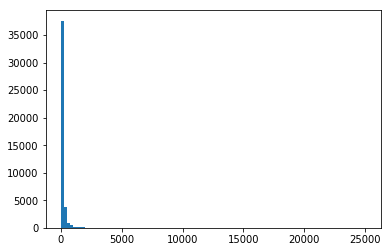

In [9]:
plt.hist(listings['price'],bins=100);

In [10]:
print(np.max(listings['price']))
print(np.percentile(listings['price'],97))

25000.0
800.0


So price is havily skewed on the right. With the maximum price of 25000 97% of listings have price less than 800. The ultra-expensive listings are very rare, so let us cut the outlying 3% to get a better understanding of the biggest part of the population

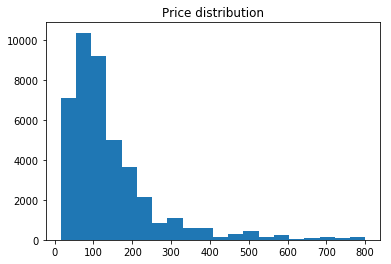

In [11]:
percentile_threshold=97
listings=listings[listings['price']<=np.percentile(listings['price'],percentile_threshold)]
plt.title('Price distribution')
plt.hist(listings['price'],bins=20);

In [12]:
print('First quartile:',np.percentile(listings['price'],25))
print('Median:',np.percentile(listings['price'],50))
print('Third quartile:',np.percentile(listings['price'],75))

First quartile: 70.0
Median: 104.0
Third quartile: 175.0


mean: 4.704633536214335
standard deviation: 0.7063041571925379
quartiles: [4.24849524 4.6443909  5.16478597]
mode: 4.605170185988092
percentage of data in [mu-sigma,mu+sigma] 68.94154370034052


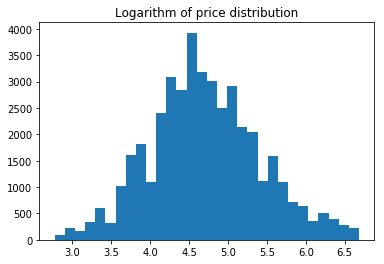

In [13]:
# Let us see the distribution of the logarithm of the price
plt.title('Logarithm of price distribution')
plt.hist(np.log(listings['price']),bins=30);
mu=np.mean(np.log(listings['price']))
sigma=np.std(np.log(listings['price']))
print('mean:',mu)
print('standard deviation:',sigma)
print('quartiles:',np.percentile(np.log(listings['price']),[25,50,75]))
print('mode:',stats.mode(np.log(listings['price']))[0][0])
print('percentage of data in [mu-sigma,mu+sigma]',stats.percentileofscore(np.log(listings['price']),mu+sigma)-stats.percentileofscore(np.log(listings['price']),mu-sigma))

The logarithm of price seems to be distributed symmetrically. The spikes in the distribution seem to be caused by advertising reasons: the biggest change is at level log=4.6, corresponds to the fact that most people will advertise their place for 99\$ rather than 101\$, the next psychological thresholds we see at log=5, log=5.3 that correspond to the price levels of 150\$ and 200\$.

We see that log price distribution seems very similarr to the normal one. It is symmetric, 68% of the data have values within one standard deviation of the mean. Let us test the hypothesis that log prices are distributed normally using Pearson's $\chi^2$-test with 20 bins. We will see that the Pearson test rejects the hypothesis:

chi squared statistics:  837.6449686245796 p-value:  1.670331414709071e-174


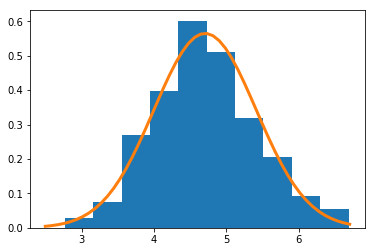

In [14]:
# number of bins:
n=10
# number of observations:
N=listings['price'].shape[0]
mu=np.mean(np.log(listings['price']))
sigma=np.std(np.log(listings['price']))
x=np.linspace(2.5,6.7)
y=stats.norm.pdf(x,loc=mu,scale=sigma)
plt.hist(np.log(listings['price']),density=True,bins=n);
plt.plot(x,y,linewidth=3);
# Compute the observed and expected frequencies:
histogram,bins_boundaries=np.histogram(np.log(listings['price']),density=True,bins=n)
bin_width=bins_boundaries[1]-bins_boundaries[0]
observed_probabilities=histogram*bin_width
expected_probabilities=stats.norm.cdf(bins_boundaries[1:],loc=mu,scale=sigma)-stats.norm.cdf(bins_boundaries[:-1],loc=mu,scale=sigma)
# add the tails to the first and last bins
expected_probabilities[0]+=stats.norm.cdf(bins_boundaries[0],loc=mu,scale=sigma) 
expected_probabilities[-1]+=1-stats.norm.cdf(bins_boundaries[-1],loc=mu,scale=sigma) 
# Compute the chi-squared statistics
observed_frequencies=observed_probabilities*N
expected_frequencies=expected_probabilities*N
print('chi squared statistics: ',stats.chisquare(observed_frequencies,expected_frequencies)[0],'p-value: ',stats.chisquare(observed_frequencies,expected_frequencies)[1])
# So chi square statistics is too high so we can not assume that distribution is normal.

So despite the fact that the log price histogram looks like a bell-shaped curves, the Pearson's test rejects the normality hypothesis. This is mainly because of the fact that we have 40000 observations. If they were distributed normally, the fit should have been much better.

### 2.2. Geographical price distribution
We will use the gmplot package to colour each neighbourhood with respect to the average price and amount of listings of each type.

In [15]:
# create the spectrum from green to red
number_colors=10
colors = list(Color('green').range_to(Color('red'),number_colors))
colors=[c.hex_l for c in colors]

apikey=#google maps javascirpt api key https://developers.google.com/maps/documentation/javascript/get-api-key

# create gmplot maps, one for each room_type and price/number of listings
gmap_mean_price = gmplot.GoogleMapPlotter.from_geocode("Los Angeles",apikey=apikey)
gmap_std_price = gmplot.GoogleMapPlotter.from_geocode("Los Angeles",apikey=apikey)
gmap_count = gmplot.GoogleMapPlotter.from_geocode("Los Angeles",apikey=apikey)

def draw_nbd(map_name,name,rank):
    nbd=coords[coords['neighbourhood']==name].iloc[0]
    gg=list(nbd['geometry'])

    for g in gg:
        lon,lat=g.exterior.coords.xy
        eval('gmap_'+map_name).polygon(lat, lon, face_alpha=0.8, color=colors[int(rank*(number_colors-1))])

listings['logprice']=np.log(listings['price'])        
mean_price=listings.groupby('neighbourhood_cleansed')['logprice'].mean()
std_price=listings.groupby('neighbourhood_cleansed')['logprice'].std()
counts=listings.groupby('neighbourhood_cleansed')['id'].count()
listings=listings.drop(columns=['logprice'])
# Reduce noise: exclude neighborhoods with less than 10 listings
counts=counts[counts>10]
for nbd in counts.index:
    draw_nbd('mean_price',nbd,((stats.percentileofscore(mean_price, mean_price[nbd]))/100))
    draw_nbd('std_price',nbd,((stats.percentileofscore(std_price, std_price[nbd]))/100))
    draw_nbd('count',nbd,((stats.percentileofscore(counts, counts[nbd]))/100))
gmap_mean_price.draw('gmap_mean_price.html')
gmap_std_price.draw('gmap_std_price.html')
gmap_count.draw('gmap_count_price.html')                     

/home/neshitov/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1795: RuntimeWarning: invalid value encountered in less
  left = np.count_nonzero(a < score)
/home/neshitov/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1796: RuntimeWarning: invalid value encountered in less_equal
  right = np.count_nonzero(a <= score)


The following map shows the average price, standard deviation and number of listings for each of the neighborhood. All neighborhoods are colored in 10 colors with top 10% neighbourhoods are marked red and bottom 10% neighbourhoods marked green.

In [16]:
%%HTML
<!DOCTYPE html>
<html>
<body>

<select id="sel1", onchange="run()">
  <option value="mean">Average price</option>
  <option value="std">Standard deviation</option>
  <option value="count">Number of listings</option>
</select>
<iframe id="map", width="100%" height="350" src="gmap_mean_price.html"></iframe>

<script>
function run(){
    var ttype = document.getElementById("sel1").value;
    var nname = "gmap_"+ttype+"_price.html"
    document.getElementById("map").setAttribute("src",nname)
}

</script>

</body>
</html>

**Geographical distribution:**
So we see that on average the most expensive neighborhoods are those close to the ocean (not surprisingly)
The biggest standard deviation (of the logarithm of the price) is in Montebello and Glendora
The biggest amount of listings there are in Santa Monica, Hollywood, Downtown and Long Beach and Pasadena.


### 2.3. How different features affect the price.


#### Question1: Is it true that hosts with superhost status earn more?

number of superhost listings:  11155
number of nonsuperhosts listings:  31133
142.3976692066338 110.0 110.72070569501106
143.68358333601003 100.0 123.87679982680676


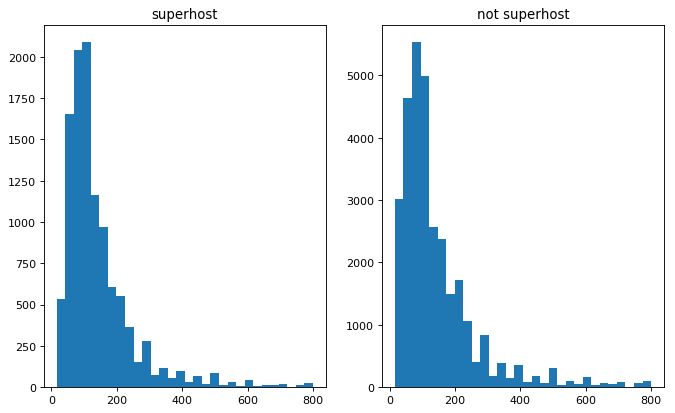

In [17]:
listings_superhost=listings[listings['host_is_superhost']==True]
listings_nonsuperhost=listings[listings['host_is_superhost']==False]
print('number of superhost listings: ', listings_superhost.shape[0])
print('number of nonsuperhosts listings: ', listings_nonsuperhost.shape[0])
print(np.mean(listings_superhost['price']), np.median(listings_superhost['price']),np.std(listings_superhost['price']))
print(np.mean(listings_nonsuperhost['price']),np.median(listings_nonsuperhost['price']),np.std(listings_nonsuperhost['price']))
plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1).set_title('superhost')
plt.hist(listings_superhost['price'],bins=30);
plt.subplot(1,2,2).set_title('not superhost')
plt.hist(listings_nonsuperhost['price'],bins=30);
plt.show()

So we see that there is no big difference for mean, but there is some difference in the median and standard deviation. Let's use bootstrapping to construct confidence interval for the median of the superhost-listing population and non-superhost listing population. We will use the following fact (Proposition 5.1 of "Some asymptotic theory for the bootstrap" by Bickel and Freedman):
if $X_1,\ldots,X_n$ is a sequence of i.i.d random variables, $\mu$ is the median of their common distribution, $m$ is the median of the sample $X_1,\ldots,X_n$ and $m^*$ is the median of the bootstrap $X_1^*,\ldots,X_n^*$ conditionally for $X_1,\ldots,X_n$, then 
both $$\sqrt{n}(m^*-m) \text{ and } \sqrt{n}(m-\mu)$$ converge in probability to a normal distribution $N(0,\sigma^2)$ with mean $0$ and the same variance $\sigma^2$. Thus with 98% chance the sample median is in $[109,110]$ with 96% probability we have that the true median is in the interval $[108,111]$. With 98% probability the sample median of the non-superhost listings equals to $100$. Thus with 96% confidence we can argue that mean of superhost listings earn $8 more than the mean of non-superhost listings.

In [18]:
N=10000
n=listings_superhost.shape[0]
medians=np.zeros(N)
for i in range(N):
    x=np.random.choice(listings_superhost['price'],n)
    medians[i]=np.median(x)
print("98% confidence interval for the sample median for superhost listings",np.percentile(medians,[1,99]))

n=listings_nonsuperhost.shape[0]
medians=np.zeros(N)
for i in range(N):
    x=np.random.choice(listings_nonsuperhost['price'],n)
    medians[i]=np.median(x)
print("98% confidence interval for the sample median for nonsuperhost listings",np.percentile(medians,[1,99]))


98% confidence interval for the sample median for superhost listings [109. 110.]
98% confidence interval for the sample median for nonsuperhost listings [100. 100.]


#### Question2:  Does the absence of reviews affect price significantly?

number of listings with reviews  33934
number of listings without reviews  8354
reviews, mean:  138.82710555784757 standard deviation:  113.49205415148002
no reviews, mean:  161.69355997127124 standard deviation:  144.28858754010065


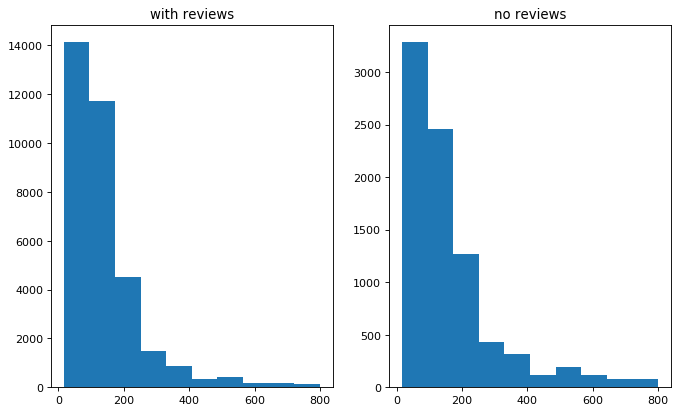

In [19]:
listings_reviews=listings[listings['number_of_reviews']>0]
listings_no_reviews=listings[listings['number_of_reviews']==0]
print('number of listings with reviews ',listings_reviews.shape[0])
print('number of listings without reviews ',listings_no_reviews.shape[0])
print('reviews, mean: ',np.mean(listings_reviews['price']),'standard deviation: ',np.std(listings_reviews['price']))
print('no reviews, mean: ',np.mean(listings_no_reviews['price']),'standard deviation: ',np.std(listings_no_reviews['price']))
plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1).set_title('with reviews')
plt.hist(listings_reviews['price'],bins=10);
plt.subplot(1,2,2).set_title('no reviews')
plt.hist(listings_no_reviews['price'],bins=10);
plt.show()

Surprisingly, the mean for sample of listings without review is bigger than the mean of sample with reviews. Let us see if this is statistically significant

98% confidence interval for the sample mean for listings with reviews [137.36725968 140.26278305]
98% confidence interval for the sample mean for listings without reviews [158.17603424 165.31687575]


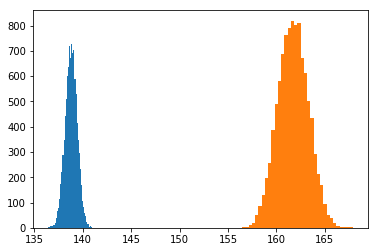

In [20]:
# We could use Students t-distribution here and construct confidence intervals for mean analytically, 
# but let's just use bootstrapping
N=10000
n=listings_reviews.shape[0]
means=np.zeros(N)
for i in range(N):
    x=np.random.choice(listings_reviews['price'],n)
    means[i]=np.mean(x)
plt.hist(means,bins=40);
print("98% confidence interval for the sample mean for listings with reviews",np.percentile(means,[1,99]))

n=listings_no_reviews.shape[0]
means=np.zeros(N)
for i in range(N):
    x=np.random.choice(listings_no_reviews['price'],n)
    means[i]=np.mean(x)
plt.hist(means,bins=40);
print("98% confidence interval for the sample mean for listings without reviews",np.percentile(means,[1,99]))


So we see that with 96% confidence the listings population mean is 18$ less than no-listings population mean.
Thus we see that ctrict cancellation policy is more likely associated with more expensive rooms. This is quit surprising to see as one could expect that new listings will be advertised for lower price to attract guests. One possible explanation could be that new listings can appear in newly built houses that should be more expensive.

#### Question3: Does cancellation policy matter?

In [21]:
print(listings['cancellation_policy'].unique())
print(listings.groupby('cancellation_policy')['id'].count())

['strict_14_with_grace_period' 'flexible' 'moderate' 'super_strict_30'
 'strict' 'super_strict_60']
cancellation_policy
flexible                       12918
moderate                       11754
strict                            33
strict_14_with_grace_period    17416
super_strict_30                   10
super_strict_60                  157
Name: id, dtype: int64


flexible (12918, 77)
strict (17416, 77)
flexible 121.57408267533674 90.0 107.5409032610254
strict 163.14796738631145 125.0 132.5750477977592


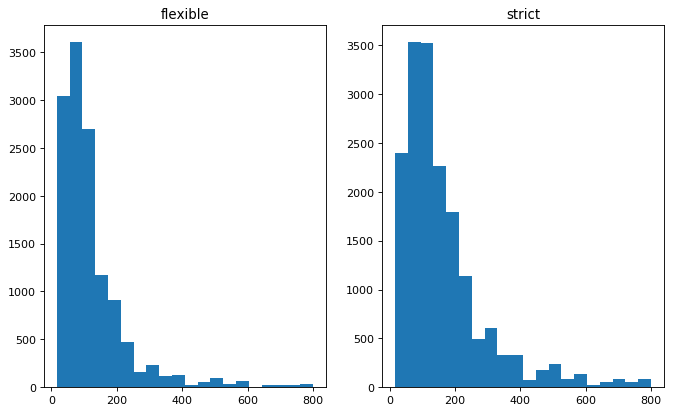

In [22]:
title_1='flexible'
title_2='strict'
listings_1=listings[listings['cancellation_policy']=='flexible']
listings_2=listings[listings['cancellation_policy']=='strict_14_with_grace_period']
print(title_1,listings_1.shape)
print(title_2,listings_2.shape)
print(title_1,np.mean(listings_1['price']), np.median(listings_1['price']),np.std(listings_1['price']))
print(title_2,np.mean(listings_2['price']),np.median(listings_2['price']),np.std(listings_2['price']))
plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1).set_title(title_1)
plt.hist(listings_1['price'],bins=20);
plt.subplot(1,2,2).set_title(title_2)
plt.hist(listings_2['price'],bins=20);
plt.show()

99% confidence interval for the sample mean with flexible cancellation policy [119.09873665 124.05324934]
99% confidence interval for the sample mean with strict cancellation policy [159.39727376 166.95812006]


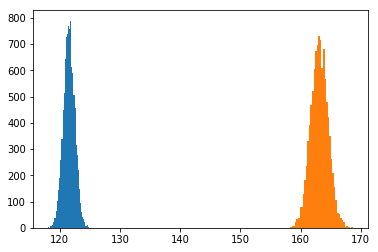

In [23]:
# Let's use bootratpping
N=10000
n=listings_1.shape[0]
means=np.zeros(N)
for i in range(N):
    x=np.random.choice(listings_1['price'],n)
    means[i]=np.mean(x)
plt.hist(means,bins=40);
print("99% confidence interval for the sample mean with flexible cancellation policy",np.percentile(means,[0.5,99.5]))

n=listings_no_reviews.shape[0]
means=np.zeros(N)
for i in range(N):
    x=np.random.choice(listings_2['price'],n)
    means[i]=np.mean(x)
plt.hist(means,bins=40);
print("99% confidence interval for the sample mean with strict cancellation policy",np.percentile(means,[0.5,99.5]))


So with 98% confidence we can state that listings with strict cancellation policy cost 35 dollars more than listings with flexible cancellation policy.

## 3. Price prediction models
To see how different features affect the price of a listings we will build a model that predicts the price of a listings based on its features.

### 3.1. Linear regression
**Linear regression** Let's start with the simplest linear regression model as it will allow us to estimate the weights of different features. When predicting a price of a listing it seems that the relative error in price prediction is more important than the absolute error: making 50\$ error while predicting the price of 500\$-range listings is not as bad as making 50\$ error while predicting the price of 60\$-range listing. Therefore we will construct linear regressor that predicts logarithm of the price rather than price itself.

In [24]:
#Start with linear regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
listings_lr=listings.copy()
listings_lr=pd.get_dummies(listings_lr,prefix=['','type','bed','cancel','nbd'],columns=['property_type','room_type','bed_type','cancellation_policy','neighbourhood_cleansed'])
features=listings_lr.drop(columns=['id','maximum_nights','price'])

#amenities_variance={}
#for x in amenities:
#    amenities_variance[x]=np.var(listings_lr[x])
#amenities_variance=OrderedDict(sorted(amenities_variance.items(), key=operator.itemgetter(1)))
#for x in amenities_variance:
#    print(x,amenities_variance[x])
# fill missing values with zeros for the logistic regression
#features=features.fillna(0)
logprices=np.log(listings_lr['price'])
features_train, features_test, logprices_train, logprices_test= train_test_split(features,logprices,random_state=42)
# apply the RobustScaler to ensure that all features are on the same scale.
scaler=RobustScaler()
numerical_columns=['accommodates','bathrooms','bedrooms','beds','guests_included','minimum_nights',
'number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value',
'reviews_per_month']

features_train.loc[:,numerical_columns]=scaler.fit_transform(features_train.loc[:,numerical_columns])
features_test.loc[:,numerical_columns]=scaler.transform(features_test.loc[:,numerical_columns])

/home/neshitov/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


train relative error 50,75,90,95 percentile: 
[0.20986664 0.37257238 0.56998248 0.73193822]
test relative error 50,75,90,95 percentile: 
[0.21504969 0.38062032 0.59204049 0.74788401]


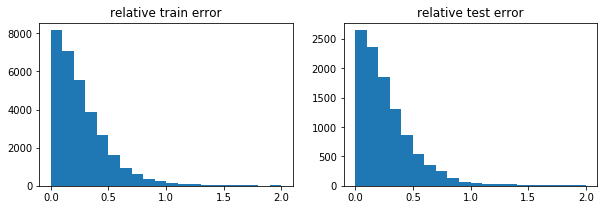

In [25]:
#Let's use ridge regression to prevent overfitting
lm=Ridge(alpha=0.9)
#lm=LinearRegression()
lm=lm.fit(features_train,logprices_train)
#Analyze the performance: take exponent to get the prices of the listings and compute relative errors
prices_train_pred, prices_test_pred=np.exp(lm.predict(features_train)), np.exp(lm.predict(features_test))
train_relative_error=np.abs(np.exp(logprices_train)-prices_train_pred)/np.exp(logprices_train)
test_relative_error=np.abs(np.exp(logprices_test)-prices_test_pred)/np.exp(logprices_test)
plt.figure(figsize=(10,3))
plt.subplot(1,2,1).set_title('relative train error')
plt.hist(train_relative_error,range=[0,2],bins=20);
plt.subplot(1,2,2).set_title('relative test error')
plt.hist(test_relative_error,range=[0,2],bins=20);

print('train relative error 50,75,90,95 percentile: ')
print(np.percentile(train_relative_error,[50,75,90,95]))
print('test relative error 50,75,90,95 percentile: ')
print(np.percentile(test_relative_error,[50,75,90,95]))


In [26]:
# Create a table to compare the model prediction results. This will be a dictionary with keys: model names and
# parameters and values given by the list of test error percentiles
benchmark={}
benchmark['ridge regression, alpha=0.1']=np.percentile(test_relative_error,[50,75,90,95])

**Features impact**: Let's see the features that have the biggest impact on the price

In [27]:
features_dict=OrderedDict(list((features.columns[i],lm.coef_[i]) for i in range(features.shape[1])))
features_dict=OrderedDict(sorted(features_dict.items(), key=operator.itemgetter(1),reverse=True))
# Let us print all coefficients with magnitude bigger than 0.1
print('Neighborhoods:')
for x in features_dict.items():
    if 'nbd_' in x[0] and np.abs(x[1])>0.1:
        print(x[0],x[1])
print('intercept',lm.intercept_)        
print('Other features:')        
for x in features_dict.items():
    if 'nbd_' not in x[0] and np.abs(x[1])>0.05:
        print(x[0],x[1])

#print('non-neighborhood related features')
#print(list(x for x in features_dict.items() if 'nbd_' not in x[0]))

#print(lm.coef_)

Neighborhoods:
nbd_Malibu 0.8522729620627627
nbd_Unincorporated Catalina Island 0.7659742454398452
nbd_Avalon 0.637937080057871
nbd_Unincorporated Santa Monica Mountains 0.5844284950194685
nbd_Tujunga Canyons 0.577603911232852
nbd_Manhattan Beach 0.5767636753628779
nbd_Beverly Crest 0.5360536570046575
nbd_Pacific Palisades 0.5006309632231281
nbd_Citrus 0.4829863314149126
nbd_Venice 0.4802108879061485
nbd_Hollywood Hills West 0.4564205120140054
nbd_Ramona 0.4494112312232769
nbd_Santa Monica 0.44064986288857133
nbd_Beverly Hills 0.42703809401755444
nbd_Hermosa Beach 0.3898331774301648
nbd_Bel-Air 0.38171073447735465
nbd_Palos Verdes Estates 0.36400508087388206
nbd_Northeast Antelope Valley 0.35599162254838373
nbd_San Marino 0.3231788339583595
nbd_Topanga 0.3198087536530818
nbd_Beverly Grove 0.31660507170205054
nbd_Hawaiian Gardens 0.3161323120806699
nbd_Playa del Rey 0.31572988956331755
nbd_West Hollywood 0.30466143100634746
nbd_Hancock Park 0.2889299568612727
nbd_Marina del Rey 0.282538

So we see that the neighborhood features have the most weight in the price determination. Among the non-neighborhood features most important are the binary features indicating type of the room ('entire home/apt'), number of bedrooms and number of people it accommodates. Among the review features the most important seems to be the cleanliness score, the most important amenities are indoor fireplace, TV and Dishwasher.
Thus if we accept the linear regression model for the logarithm of the price, then we have the following impacts of the amenities: we see theat indoor fireplace adds 6.5% to the price of the listing, TV adds 6.3%, Dishwasher adds 6.1%. 

Surprisingly we see that some amenities have negative weight: like the weight of wifi amenity is -0.12. An explanation of this is that in fact almost all of the listings do have wifi in their list of amenities. Thus the Wifi variable might serve as a way for regressor to indicate the ouliers.

### 3.2 AdaBoost and random forest
Now let's try to construct a better model by using decision trees. We will use adaboost on decision tree and random forest with different parameters and then will choose the model with the best test set performance.

In [28]:
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

listings_adaboost=listings.copy()
listings_adaboost=pd.get_dummies(listings_adaboost,prefix=['','type','bed','cancel','nbd'],columns=['property_type','room_type','bed_type','cancellation_policy','neighbourhood_cleansed'])

features=listings_adaboost.drop(columns=['id','maximum_nights','price'])
# fill missing values with zeros for decision trees. That will allow algorithm to see use the fact that 
# some information is missing
features=features.fillna(-10)

logprices=np.log(listings_adaboost['price'])
features_train, features_test, logprices_train, logprices_test= train_test_split(features,logprices,random_state=42)

def test_error(regressor,features_test,logprices_test):
    prices_test_pred= np.exp(regressor.predict(features_test))
    test_relative_error=np.abs(np.exp(logprices_test)-prices_test_pred)/np.exp(logprices_test)
    percentiles=np.percentile(test_relative_error,[50,75,90,95])
    print(percentiles)
    return percentiles

for md in [5,10,20,30,40]:
    for n_estim in [20,30,40,50]:
        ab=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=md),n_estimators=n_estim,random_state=42)
        ab.fit(features_train,logprices_train)
        benchmark['adaboost, max_depth='+str(md)+', n_estimators='+str(n_estim)]=test_error(ab,features_test,logprices_test)
        rf=RandomForestRegressor(max_depth=md,n_estimators=n_estim ,min_samples_leaf=0.001,random_state=42)
        rf.fit(features_train,logprices_train)
        benchmark['random forest, max_depth='+str(md)+', n_estimators='+str(n_estim)]=test_error(rf,features_test,logprices_test)

#prices_train_pred, prices_test_pred=np.exp(ab.predict(features_train)), np.exp(ab.predict(features_test))
#train_relative_error=np.abs(np.exp(logprices_train)-prices_train_pred)/np.exp(logprices_train)
#test_relative_error=np.abs(np.exp(logprices_test)-prices_test_pred)/np.exp(logprices_test)
#plt.figure(figsize=(10,3))
#plt.subplot(1,2,1).set_title('AdaBoost, relative train error')
#plt.hist(train_relative_error,range=[0,2],bins=20);
#plt.subplot(1,2,2).set_title('AdaBoost, relative test error')
#plt.hist(test_relative_error,range=[0,2],bins=20);

#print('train relative error 50,75,90,95 percentile: ')
#print(np.percentile(train_relative_error,[50,75,90,95]))
#print('test relative error 50,75,90,95 percentile: ')
#print(np.percentile(test_relative_error,[50,75,90,95]))


[0.28353356 0.51232031 0.80848596 1.07442561]
[0.25513248 0.44331082 0.65910425 0.84545309]
[0.29097234 0.53099073 0.84000578 1.14889266]
[0.2559391  0.44188286 0.66153881 0.84436421]
[0.30050569 0.55059506 0.87617691 1.18010397]
[0.25635899 0.44292339 0.66141474 0.84360163]
[0.30528837 0.55869996 0.8927071  1.19132607]
[0.2553167  0.44285816 0.6594844  0.84304109]
[0.23340643 0.42028447 0.64623813 0.83228199]
[0.22692753 0.41213223 0.62013236 0.79116543]
[0.23907736 0.42485196 0.65271467 0.83521201]
[0.22784421 0.41085566 0.6208639  0.79484964]
[0.24269928 0.43473862 0.66135332 0.85250558]
[0.22806194 0.41122296 0.62052945 0.79493532]
[0.24471315 0.43737694 0.66814496 0.85162739]
[0.22713649 0.40808157 0.62289159 0.79752648]
[0.20613984 0.37589321 0.57590266 0.73414266]
[0.22415052 0.40079101 0.61651021 0.78800165]
[0.20300742 0.37288923 0.57969853 0.72802136]
[0.2227046  0.3979888  0.61454467 0.79373484]
[0.20267849 0.37142857 0.57649528 0.73760231]
[0.22306135 0.3997239  0.61492069 

### 3.3 Gradient boosting trees
Another algorithm that is worth trying is gradient boosting on trees. We will use CatBoost, a gradient boosting algorithm with categorical features support.

In [29]:
from catboost import Pool, CatBoostRegressor

listings_tree=listings.copy()
logprices=np.log(listings_tree['price'])
features=listings_tree.drop(columns=['id','price'])

features_train, features_test, logprices_train, logprices_test= train_test_split(features,logprices,random_state=42)
categorical_columns=['neighbourhood_cleansed','property_type','room_type','bed_type','cancellation_policy']
cat_feature_indices=[list(features.columns).index(cc) for cc in categorical_columns]

train_pool = Pool(features_train, logprices_train, cat_features=cat_feature_indices)
test_pool = Pool(features_test, logprices_test, cat_features=cat_feature_indices)

model = CatBoostRegressor(iterations=5000, depth=3,od_type='Iter',od_wait=300, loss_function='RMSE')
model.fit(train_pool,eval_set=test_pool,use_best_model=True,verbose=1000)
benchmark['catboost, depth=3']=test_error(model,features_test,logprices_test)

model = CatBoostRegressor(iterations=5000, depth=6,od_type='Iter',od_wait=300, loss_function='RMSE')
model.fit(train_pool,eval_set=test_pool,use_best_model=True,verbose=1000)
benchmark['catboost, depth=6']=test_error(model,features_test,logprices_test)

0:	learn: 4.6191030	test: 4.6123764	best: 4.6123764 (0)	total: 79ms	remaining: 6m 34s
1000:	learn: 0.3430211	test: 0.3526507	best: 0.3526507 (1000)	total: 13.3s	remaining: 53.2s
2000:	learn: 0.3354028	test: 0.3474341	best: 0.3474341 (2000)	total: 26.2s	remaining: 39.2s
3000:	learn: 0.3314044	test: 0.3452853	best: 0.3452853 (3000)	total: 37.7s	remaining: 25.1s
4000:	learn: 0.3290534	test: 0.3442914	best: 0.3442914 (4000)	total: 48.9s	remaining: 12.2s
4999:	learn: 0.3273350	test: 0.3436901	best: 0.3436901 (4999)	total: 1m 3s	remaining: 0us

bestTest = 0.3436901346
bestIteration = 4999

[0.19574499 0.34671766 0.54116916 0.70819355]
0:	learn: 4.6198812	test: 4.6130106	best: 4.6130106 (0)	total: 41.1ms	remaining: 3m 25s
1000:	learn: 0.3429490	test: 0.3542266	best: 0.3542264 (993)	total: 30s	remaining: 1m 59s
2000:	learn: 0.3406416	test: 0.3526726	best: 0.3526726 (1996)	total: 40.3s	remaining: 1m
3000:	learn: 0.3394302	test: 0.3518436	best: 0.3518432 (2988)	total: 51.7s	remaining: 34.5s
4000

### 3.4 Prediction model comparison
Let's compare the algorithms:

In [30]:
for x in benchmark:
    print(x,benchmark[x])

ridge regression, alpha=0.1 [0.21504969 0.38062032 0.59204049 0.74788401]
adaboost, max_depth=5, n_estimators=20 [0.28353356 0.51232031 0.80848596 1.07442561]
random forest, max_depth=5, n_estimators=20 [0.25513248 0.44331082 0.65910425 0.84545309]
adaboost, max_depth=5, n_estimators=30 [0.29097234 0.53099073 0.84000578 1.14889266]
random forest, max_depth=5, n_estimators=30 [0.2559391  0.44188286 0.66153881 0.84436421]
adaboost, max_depth=5, n_estimators=40 [0.30050569 0.55059506 0.87617691 1.18010397]
random forest, max_depth=5, n_estimators=40 [0.25635899 0.44292339 0.66141474 0.84360163]
adaboost, max_depth=5, n_estimators=50 [0.30528837 0.55869996 0.8927071  1.19132607]
random forest, max_depth=5, n_estimators=50 [0.2553167  0.44285816 0.6594844  0.84304109]
adaboost, max_depth=10, n_estimators=20 [0.23340643 0.42028447 0.64623813 0.83228199]
random forest, max_depth=10, n_estimators=20 [0.22692753 0.41213223 0.62013236 0.79116543]
adaboost, max_depth=10, n_estimators=30 [0.239077

So all the algorithms have pretty similar aaccuracy, the best one is categorical boosting with tree depth equal 3

In [31]:
model = CatBoostRegressor(iterations=5000, depth=3,od_type='Iter',od_wait=300, loss_function='RMSE')
model.fit(train_pool,eval_set=test_pool,use_best_model=True,verbose=1000)
model.get_feature_importance(data=train_pool,prettified=True)

0:	learn: 4.6182858	test: 4.6116192	best: 4.6116192 (0)	total: 35.2ms	remaining: 2m 56s
1000:	learn: 0.3439529	test: 0.3527178	best: 0.3527178 (1000)	total: 11.7s	remaining: 46.9s
2000:	learn: 0.3374266	test: 0.3479780	best: 0.3479776 (1999)	total: 25s	remaining: 37.5s
3000:	learn: 0.3341474	test: 0.3461639	best: 0.3461639 (3000)	total: 36.5s	remaining: 24.3s
4000:	learn: 0.3320782	test: 0.3451857	best: 0.3451845 (3998)	total: 47.5s	remaining: 11.9s
4999:	learn: 0.3303189	test: 0.3444063	best: 0.3444062 (4998)	total: 58.6s	remaining: 0us

bestTest = 0.3444061797
bestIteration = 4998

Shrink model to first 4999 iterations.


[(b'room_type', 42.93454857420088),
 (b'bedrooms', 18.205232788697863),
 (b'neighbourhood_cleansed', 7.778907536017186),
 (b'accommodates', 7.660306187409178),
 (b'bathrooms', 3.907956483437008),
 (b'reviews_per_month', 1.7074017682172764),
 (b'property_type', 1.3455457376235422),
 (b'beds', 1.249714025618991),
 (b'Garden or backyard', 1.1709206837091048),
 (b'Indoor fireplace', 1.1702970966126411),
 (b'TV', 1.0191422686008256),
 (b'minimum_nights', 0.9402433023828838),
 (b'review_scores_location', 0.6325347067132768),
 (b'Washer', 0.6264640058701735),
 (b'guests_included', 0.6004737880003784),
 (b'review_scores_rating', 0.5469157943439144),
 (b'Free parking on premises', 0.4958676518264502),
 (b'Cable TV', 0.4951974326854909),
 (b'review_scores_cleanliness', 0.4871413601694906),
 (b'cancellation_policy', 0.4373734551428165),
 (b'Pool', 0.43594023282068767),
 (b'review_scores_value', 0.3815815427890738),
 (b'Kitchen', 0.3799088820048146),
 (b'number_of_reviews', 0.33354898875107863),
 

Feature importance for the gradient boosting model is quite different from what we saw in the linear regression model. The most important features are the room_type feature and number of bedrooms. Next features are features indicating the size (number of people that the property accommodates, number of bathrooms, etc.). Among the amenities features the most important are 'Garden or Backyard'(that did not show up in the linear model) and the fireplace and TV, which also were most important amenities in linear regression.


## 4. Interval price prediction
We can see from the previous discussion that the features that we use do not determine the price completely. When the features are known we thus get a conditional distribution of the price and so far we were constructing models that predict mean of this conditional distribution. For the practical purposes it is important to predict some interval where the price most likely fit. So we will construct a model that predicts standard deviation of the conditional distribution.

In [32]:
logprices_train_pred=model.predict(features_train)
logprices_test_pred=model.predict(features_test)
variance_model= CatBoostRegressor(iterations=5000, depth=3,od_type='Iter',od_wait=300, loss_function='RMSE')
variance_train_pool = Pool(features_train, (logprices_train_pred-logprices_train)**2, cat_features=cat_feature_indices)
variance_test_pool = Pool(features_test, (logprices_test_pred-logprices_test)**2, cat_features=cat_feature_indices)
variance_model.fit(variance_train_pool,eval_set=variance_test_pool,use_best_model=True,verbose=1000)
  

0:	learn: 0.2599681	test: 0.2844196	best: 0.2844196 (0)	total: 12.3ms	remaining: 1m 1s
1000:	learn: 0.2292064	test: 0.2530528	best: 0.2530520 (989)	total: 12.3s	remaining: 49s
2000:	learn: 0.2279862	test: 0.2529342	best: 0.2529342 (2000)	total: 24.6s	remaining: 36.8s
3000:	learn: 0.2270912	test: 0.2528437	best: 0.2528437 (2998)	total: 37.1s	remaining: 24.7s
4000:	learn: 0.2264496	test: 0.2528016	best: 0.2527988 (3983)	total: 49.5s	remaining: 12.4s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.252773597
bestIteration = 4605

Shrink model to first 4606 iterations.


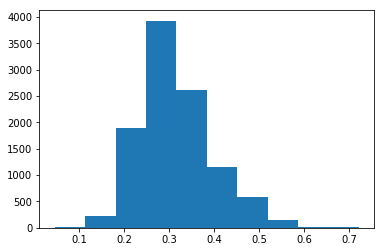

In [37]:
test_std_pred=np.sqrt(np.abs(variance_model.predict(features_test)))
test_std_pred=np.nan_to_num(test_std_pred)
plt.hist(test_std_pred);

In [34]:
#Let's see what percentage of test results falls into standard deviation
g=np.abs(logprices_test-model.predict(features_test))<test_std_pred
print(str((np.sum(g)/g.shape[0])*100)[0:3]+'% of all test points fall into predicted std')
g=np.abs(logprices_test-model.predict(features_test))<2*test_std_pred
print(str((np.sum(g)/g.shape[0])*100)[0:3]+'% of all test points fall into 2*predicted std')

68.% of all test points fall into predicted std
94.% of all test points fall into 2*predicted std
